# IPSC Model Detection Example

The model is comprised of a few steps that will be demonstrated here. The first step will be **importing and preprocessing** of files followed by **feature extraction**, **prediction** and  finally **value export**. 

These steps are implemented as a methods from the RecordingFile class which will be demonstrated here.

## Import and Prep

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, MaxPooling1D, Conv1D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.signal import find_peaks
from scipy import signal
import pyabf
from tqdm import tqdm
import pickle
from Preprocessing import preprocessing
from Classes import *

## Importing a File

The first step for the model is importing a single file. Details on how to import and analyze a batch ofrecordings all at the same time will be detailed later. Importing a file is done by creating a RecordingFile object with the path to the recording file as an arguement. The example file is inlcuded in the project for simplicity. For the sake of speed, we will only load the first portion of a recording by switch thing arguement Slicer to be True, which is nativly set to False. 

The abf_init method returns a Pandas DataFrame with two columns, Time and Current. The current can be visualized below.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.2s finished


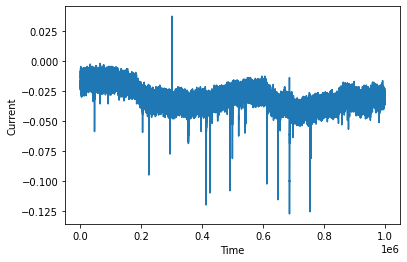

In [6]:
# Path to the test file
test_file_path = '7_30_2019 264 Continuous Export.abf'

# Creation of the RecordingFile object
abf = RecordingFile(test_file_path)
trace = abf.abf_init

# Display the recording that was loaded
plt.plot(trace['Current'])
plt.xlabel('Relative Time')
plt.ylabel('Current')
plt.show()

## Filtering and Smoothing

Before feature extraction and prediction can occur, the data should be filtered and smoothed. This helps adjust for electrode drift, decreases noise, slightly dosnsamples the data to speed processing and acts as a relative normalizer. For more details on why and how this was done, see the manuscript. 

First the recording is filtered using THIS function from the RecordingFile class. Then the smoothing function is applied as THIS function from the same class. 

In [30]:
# Filters the trace
filt = abf.apply_filter(trace)

# Smoothes the trace
smth = abf.smooth_trace(filt)

These functions can be visualized below.

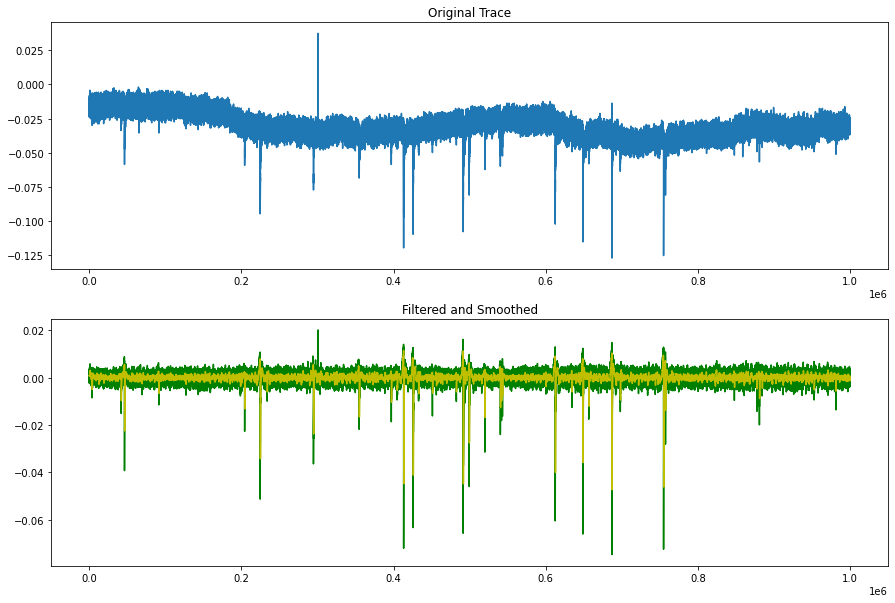

In [31]:
# Visualizes all three traces side by side
fig, axs = plt.subplots(2, figsize = (15,10))

axs[0].plot(trace['Current'])
axs[1].plot(filt['Current_F'], color='g')
axs[1].plot(smth['Current_F'], color='y')

axs[0].set_title('Original Trace')
axs[1].set_title('Filtered and Smoothed')

plt.show()

## Finding Potential Peaks

After preprocessing is complete, we then try to fidn all possible places where peaks might occur. This can save on training and prediction time. For more details on the tools used to do this, check the manuscript as well as this LINK.

Once again, finding potential peaks can be done using a function from the RecordingFile class. Fist, the recording must be inverted, then passed to the find_pot_peaks function. This will return a DataFrame with two columns: Time and Current. 

In [ ]:
# Inverts the smoothed trace
inv_trace = abf.invert_trace(smth)

# Creates DataFrame of potential peaks
pot_peaks = abf.find_pot_peaks(inv_trace)

These peaks can now be displayed on top of the inverted recording. Notice that potential peaks are over exaggerated.

In [ ]:
# Displays the potential peaks on the inverted trace
plt.figure(figsize=(15,5))
sns.scatterplot(x='Time', y='Current', data=pot_peaks, color='r')
plt.plot(inv_trace['Current_F'])
plt.title('Potential Peaks')
plt.show()

## Feature Extraction

In [39]:
# Inverts the smoothed trace
inv_trace = abf.invert_trace(smth)

# Creates DataFrame of potential peaks
pot_peaks = abf.find_pot_peaks(inv_trace)

These peaks can now be displayed on top of the inverted recording. Notice that potential peaks are over exaggerated.

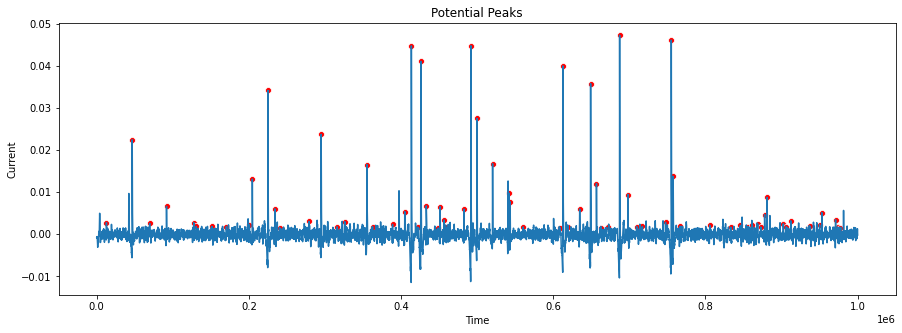

In [45]:
# Displays the potential peaks on the inverted trace
plt.figure(figsize=(15,5))
sns.scatterplot(x='Time', y='Current', data=pot_peaks, color='r')
plt.plot(inv_trace['Current_F'])
plt.title('Potential Peaks')
plt.show()

## Feature Extraction